In [1]:
import os
import math
import gc
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    explained_variance_score, max_error, median_absolute_error
)
from sklearn.neighbors import NearestNeighbors
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
import matplotlib.dates as mdates

warnings.filterwarnings('ignore')


def load_neighbor_data(neighbor_csv_path):
    """
    Load neighbor relationships from CSV file
    """
    print(f"Loading neighbor data from {neighbor_csv_path}")
    neighbor_df = pd.read_csv(neighbor_csv_path)
    
    # Create a dictionary mapping test_listing_id to its neighbors
    neighbor_dict = {}
    
    for _, row in neighbor_df.iterrows():
        test_id = row['test_listing_id']
        neighbor_id = row['neighbor_listing_id']
        rank = row['rank']
        distance = row['distance']
        
        if test_id not in neighbor_dict:
            neighbor_dict[test_id] = []
        
        neighbor_dict[test_id].append({
            'neighbor_id': neighbor_id,
            'rank': rank,
            'distance': distance
        })
    
    # Sort neighbors by rank for each test listing
    for test_id in neighbor_dict:
        neighbor_dict[test_id] = sorted(neighbor_dict[test_id], key=lambda x: x['rank'])
    
    print(f"Loaded neighbor data for {len(neighbor_dict)} test listings")
    return neighbor_dict

def extract_price_history(listing_data, date, seq_length=30):
    """
    Extract price history for a listing up to a specific date
    """
    previous_data = listing_data[listing_data['date'] < date].sort_values('date', ascending=False)
    
    # Extract prices
    price_history = []
    for _, row in previous_data.head(seq_length).iterrows():
        price_history.append(row['price'])
    
    # Pad if needed
    if len(price_history) < seq_length:
        padding = [price_history[-1] if price_history else 0] * (seq_length - len(price_history))
        price_history.extend(padding)
    
    # Keep only the most recent seq_length prices and reverse to chronological order
    price_history = price_history[:seq_length]
    price_history.reverse()
    
    return price_history

def prepare_neighbor_data_batch(test_data, train_data, neighbor_dict, max_neighbors=5, seq_length=30):
    """
    Prepare batched neighbor data for all test instances
    """
    print("Preparing neighbor data batch...")
    
    # Create lookup dictionary for train listings
    train_listings_dict = {}
    for listing_id in train_data['listing_id'].unique():
        listing_data = train_data[train_data['listing_id'] == listing_id].sort_values('date')
        train_listings_dict[listing_id] = listing_data
    
    # Initialize arrays to store neighbor histories and masks
    test_size = len(test_data)
    neighbor_histories = np.zeros((test_size, max_neighbors, seq_length), dtype=np.float32)
    neighbor_masks = np.zeros((test_size, max_neighbors), dtype=bool)
    
    # Process each test instance
    for idx, (_, test_row) in enumerate(test_data.iterrows()):
        test_id = test_row['listing_id']
        test_date = test_row['date']
        
        if test_id not in neighbor_dict:
            continue  # Skip if no neighbors found
        
        # Get neighbors for this test listing
        neighbors = neighbor_dict[test_id][:max_neighbors]
        
        # Process each neighbor
        for n_idx, neighbor in enumerate(neighbors):
            if n_idx >= max_neighbors:
                break
                
            neighbor_id = neighbor['neighbor_id']
            
            # Only use neighbors from the training set
            if neighbor_id in train_listings_dict:
                neighbor_data = train_listings_dict[neighbor_id]
                
                # Extract price history
                price_history = extract_price_history(neighbor_data, test_date, seq_length)
                
                # Store data
                neighbor_histories[idx, n_idx] = price_history
                neighbor_masks[idx, n_idx] = True
    
    print(f"Prepared neighbor data for {test_size} test instances")
    return neighbor_histories, neighbor_masks

def prepare_data_for_neighbor_lstm(train_data, test_data, neighbor_dict, property_features, 
                                 temporal_features, property_scaler=None, temporal_scaler=None, 
                                 target_scaler=None, max_neighbors=5, seq_length=30):
    """
    Prepare data for the NeighborBasedLSTM model
    """
    print("Preparing data for NeighborBasedLSTM...")
    
    # Initialize or use provided scalers
    if property_scaler is None:
        property_scaler = StandardScaler()
        property_scaler.fit(train_data[property_features])
    
    if temporal_scaler is None:
        temporal_scaler = StandardScaler()
        temporal_scaler.fit(train_data[temporal_features])
    
    if target_scaler is None:
        target_scaler = StandardScaler()
        target_scaler.fit(train_data['price'].values.reshape(-1, 1))
    
    # Scale property features
    X_train_property = property_scaler.transform(train_data[property_features]).astype(np.float32)
    X_test_property = property_scaler.transform(test_data[property_features]).astype(np.float32)
    
    # Scale temporal features
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features]).astype(np.float32)
    X_test_temporal = temporal_scaler.transform(test_data[temporal_features]).astype(np.float32)
    
    # Prepare neighbor histories for test data
    neighbor_histories, neighbor_masks = prepare_neighbor_data_batch(
        test_data, train_data, neighbor_dict, max_neighbors, seq_length
    )
    
    # Scale the target variable
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    y_test = target_scaler.transform(test_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Create data objects
    train_data_obj = Data(
        property_features=torch.FloatTensor(X_train_property),
        temporal_features=torch.FloatTensor(X_train_temporal),
        y=torch.FloatTensor(y_train.reshape(-1, 1))
    )
    
    test_data_obj = Data(
        property_features=torch.FloatTensor(X_test_property),
        temporal_features=torch.FloatTensor(X_test_temporal),
        neighbor_histories=torch.FloatTensor(neighbor_histories),
        neighbor_mask=torch.BoolTensor(neighbor_masks),
        y=torch.FloatTensor(y_test.reshape(-1, 1))
    )
    
    return train_data_obj, test_data_obj, property_scaler, temporal_scaler, target_scaler

def predict_with_neighbor_lstm(model, test_data, train_data, neighbor_dict, property_features, 
                             temporal_features, property_scaler, temporal_scaler, target_scaler,
                             max_neighbors=5, seq_length=30, device='cuda'):
    """
    Make predictions using the trained NeighborBasedLSTM model
    """
    print("\n===== Predicting with NeighborBasedLSTM Model =====")
    
    # Prepare test data
    _, test_data_obj, _, _, _ = prepare_data_for_neighbor_lstm(
        train_data, test_data, neighbor_dict, property_features, temporal_features,
        property_scaler, temporal_scaler, target_scaler,
        max_neighbors=max_neighbors, seq_length=seq_length
    )
    
    # Move to device
    test_data_obj = test_data_obj.to(device)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(test_data_obj)
        
        # Transform back to original scale
        predictions_np = target_scaler.inverse_transform(predictions.cpu().numpy())
        
        # If log-transformed, apply inverse
        predictions_orig = np.expm1(predictions_np)
    
    return predictions_orig

In [2]:
# Function to evaluate predictions
def evaluate_gnn_predictions(y_true, y_pred, print_results=True):
    """
    Evaluate GNN predictions using multiple metrics
    """
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    # Store metrics in dictionary
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }
    
    # Print results if requested
    if print_results:
        print("=== GNN Model Evaluation ===")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")
    
    return metrics

def apply_price_transformation(train_data, inverse=False):
    """
    Apply log transformation to price data or inverse the transformation
    """
    df = train_data.copy()
    
    if not inverse:
        # Apply log transformation
        print("Applying log transformation to price data")
        df['original_price'] = df['price']  # Store original price
        df['price'] = np.log1p(df['price'])  # log1p to handle zero values
    else:
        # Inverse transform
        print("Inverting log transformation for predictions")
        df['price'] = np.expm1(df['price'])  # expm1 is the inverse of log1p
    
    return df

def create_calculated_features(df):
    """
    Adapt calculated features to work with provided dataset columns
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Bedroom ratio
    if 'bedrooms' in df_copy.columns and 'accommodates' in df_copy.columns:
        df_copy['bedroom_ratio'] = df_copy['bedrooms'] / df_copy['accommodates'].clip(lower=1)
    
    # Count amenities
    amenity_columns = df_copy.filter(like='has_').columns
    if len(amenity_columns) > 0:
        df_copy['amenity_count'] = df_copy[amenity_columns].sum(axis=1)
    
    # Luxury score - use specific amenities from your dataset
    luxury_amenities = ['has_hot_water', 'has_hair_dryer', 'has_dedicated_workspace', 
                         'has_tv', 'has_wifi', 'has_shampoo']
    available_luxury = [col for col in luxury_amenities if col in df_copy.columns]
    
    if available_luxury:
        df_copy['luxury_score'] = df_copy[available_luxury].sum(axis=1) / len(available_luxury)
    else:
        df_copy['luxury_score'] = 0
    
    # Essential score - basic amenities that are essential
    essential_amenities = ['has_essentials', 'has_bed_linens', 'has_kitchen', 
                           'has_smoke_alarm', 'has_heating']
    available_essential = [col for col in essential_amenities if col in df_copy.columns]
    
    if available_essential:
        df_copy['essential_score'] = df_copy[available_essential].sum(axis=1) / len(available_essential)
    else:
        df_copy['essential_score'] = 0
    
    # Price volatility features based on rolling statistics
    if all(col in df_copy.columns for col in ['rolling_max_7d', 'rolling_min_7d']):
        df_copy['price_range_7d'] = df_copy['rolling_max_7d'] - df_copy['rolling_min_7d']
    
    if all(col in df_copy.columns for col in ['rolling_max_14d', 'rolling_min_14d']):
        df_copy['price_range_14d'] = df_copy['rolling_max_14d'] - df_copy['rolling_min_14d']
    
    if all(col in df_copy.columns for col in ['rolling_max_30d', 'rolling_min_30d']):
        df_copy['price_range_30d'] = df_copy['rolling_max_30d'] - df_copy['rolling_min_30d']
    
    # Fill any NaN values that might have been created
    numeric_cols = df_copy.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    
    return df_copy

def compare_lstm_dimensions(train_path, train_ids_path, test_ids_path, neighbor_csv_path,
                          output_dir=None, max_neighbors=5, seq_length=30, sample_size=None):
    """
    Compare LSTM models with different hidden dimensions (8 vs 16)
    """
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Set parameters for each model
    lstm_hidden_dim_1 = 8   # First LSTM hidden dimension
    lstm_hidden_dim_2 = 16  # Second LSTM hidden dimension
    
    # Run first model
    print("\n===== Running NeighborBasedLSTM Model (8 hidden dim) =====")
    result_1 = run_neighbor_lstm_model(
        train_path=train_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        neighbor_csv_path=neighbor_csv_path,
        output_dir=os.path.join(output_dir, 'lstm_dim_8') if output_dir else None,
        lstm_hidden_dim=lstm_hidden_dim_1,
        max_neighbors=max_neighbors,
        seq_length=seq_length,
        epochs=30,  # Reduced epochs for faster comparison
        sample_size=sample_size
    )
    
    # Run second model
    print("\n===== Running NeighborBasedLSTM Model (16 hidden dim) =====")
    result_2 = run_neighbor_lstm_model(
        train_path=train_path,
        train_ids_path=train_ids_path,
        test_ids_path=test_ids_path,
        neighbor_csv_path=neighbor_csv_path,
        output_dir=os.path.join(output_dir, 'lstm_dim_16') if output_dir else None,
        lstm_hidden_dim=lstm_hidden_dim_2,
        max_neighbors=max_neighbors,
        seq_length=seq_length,
        epochs=30,  # Reduced epochs for faster comparison
        sample_size=sample_size
    )
    
    # Check if both models ran successfully
    if result_1 and result_2:
        # Extract model performance
        _, _, _, _, metrics_1 = result_1
        _, _, _, _, metrics_2 = result_2
        
        # Compare metrics
        print("\n===== Model Comparison =====")
        metrics = ['rmse', 'mae', 'r2', 'mape']
        
        comparison_df = pd.DataFrame({
            'Metric': metrics,
            f'LSTM (dim={lstm_hidden_dim_1})': [metrics_1[m] for m in metrics],
            f'LSTM (dim={lstm_hidden_dim_2})': [metrics_2[m] for m in metrics]
        })
        
        # Calculate percentage change
        comparison_df['Improvement %'] = [
            ((metrics_2[m] - metrics_1[m]) / metrics_1[m] * 100) if m not in ['r2'] else
            ((metrics_2[m] - metrics_1[m]) * 100) for m in metrics
        ]
        
        print(comparison_df)
        
        # Save comparison if output_dir is provided
        if output_dir:
            comparison_df.to_csv(os.path.join(output_dir, 'lstm_dim_comparison.csv'), index=False)
            print(f"Model comparison saved to {os.path.join(output_dir, 'lstm_dim_comparison.csv')}")
        
        return comparison_df
    else:
        print("One or both models failed to run. Check error logs.")
        return None

Processing dataset: train_up3.csv
Loading data...
Loading train/test listing IDs...
Loading neighbor data from ./neighbor_data/neighbor_dict.csv
Loaded neighbor data for 1573 test listings
Loaded 6291 train IDs and 1573 test IDs
Applying log transformation to price data
Creating calculated features...
Using 2 spatial features, 6 property features, and 5 temporal features
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08
Using device: cuda

===== Split 1/5 =====
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 903142 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings

----- Training EnhancedNeighborBasedLSTM Model (Split 1) -----
Preparing data for EnhancedNeighborBasedLSTM...
Preparing neighbor data batch...
Prepared neighbor data for 11011 test instances
Building 

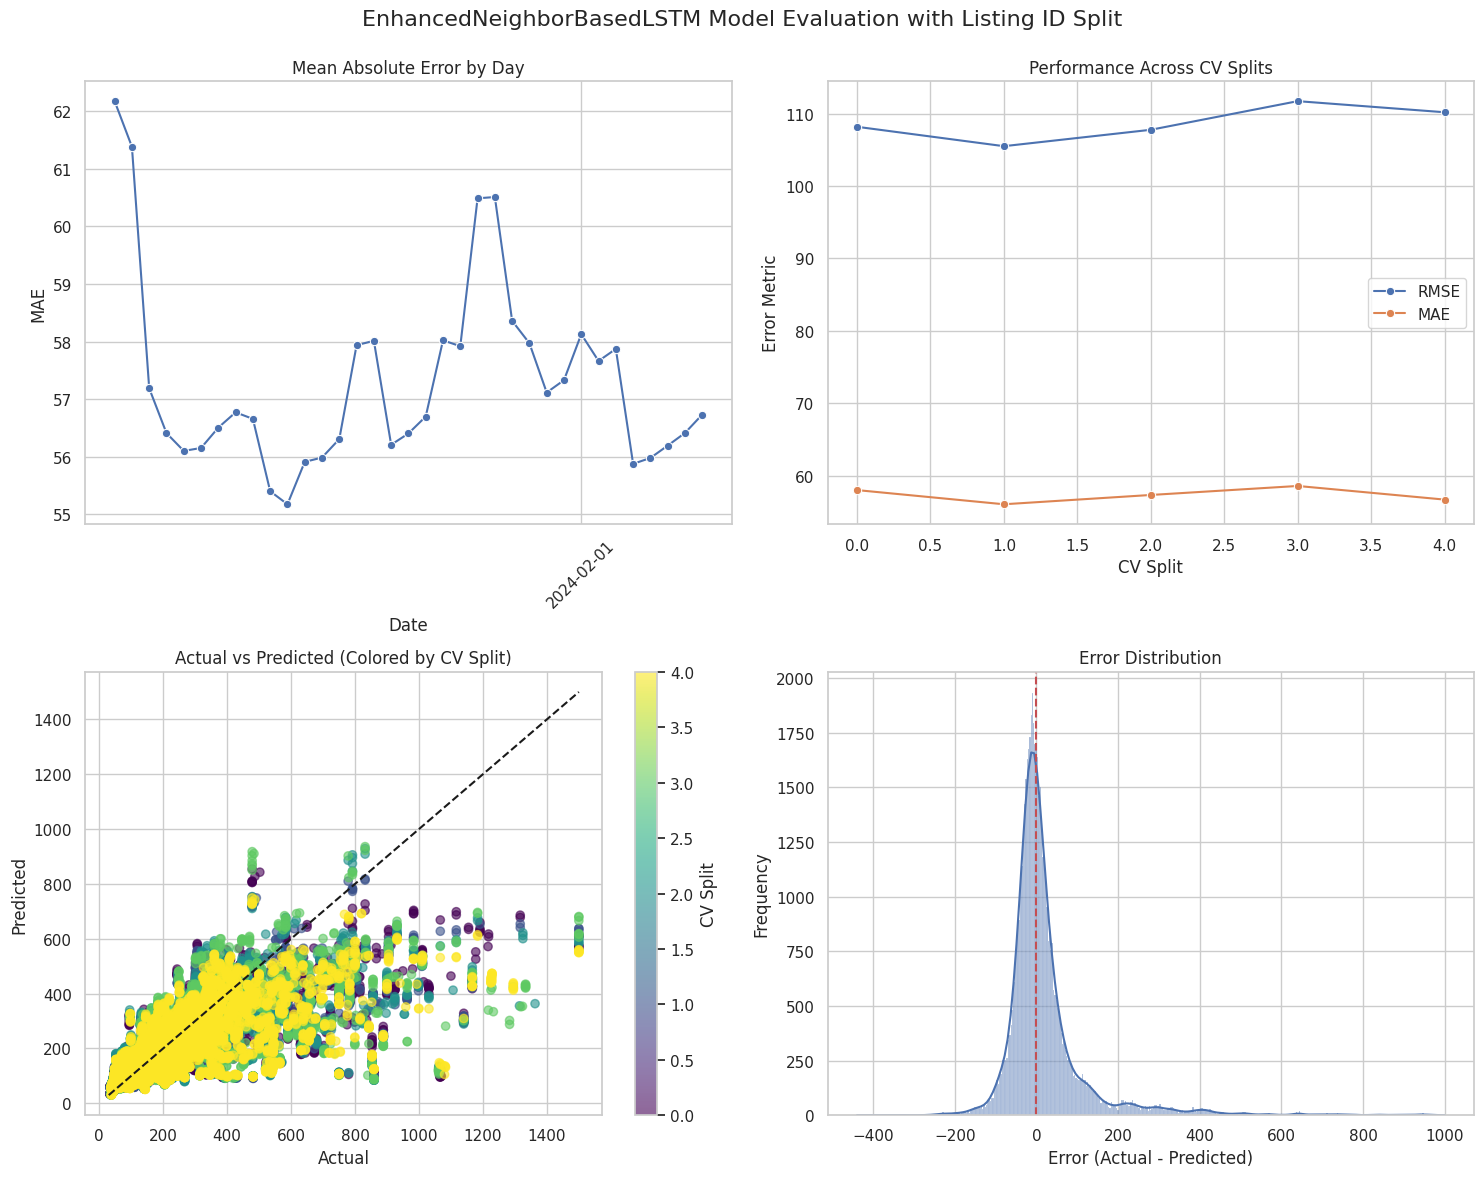

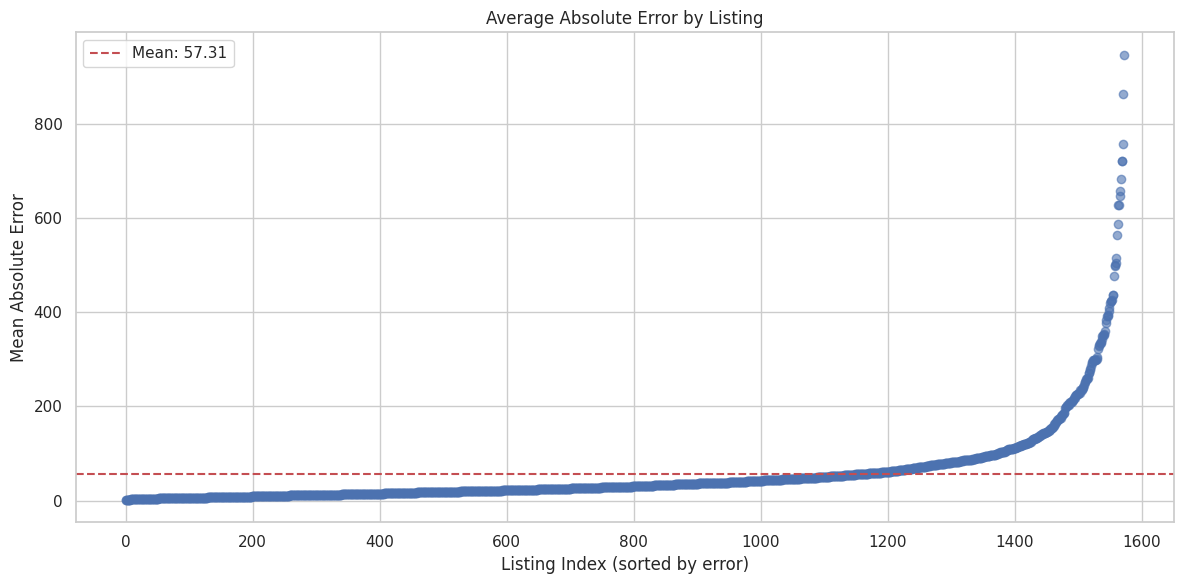

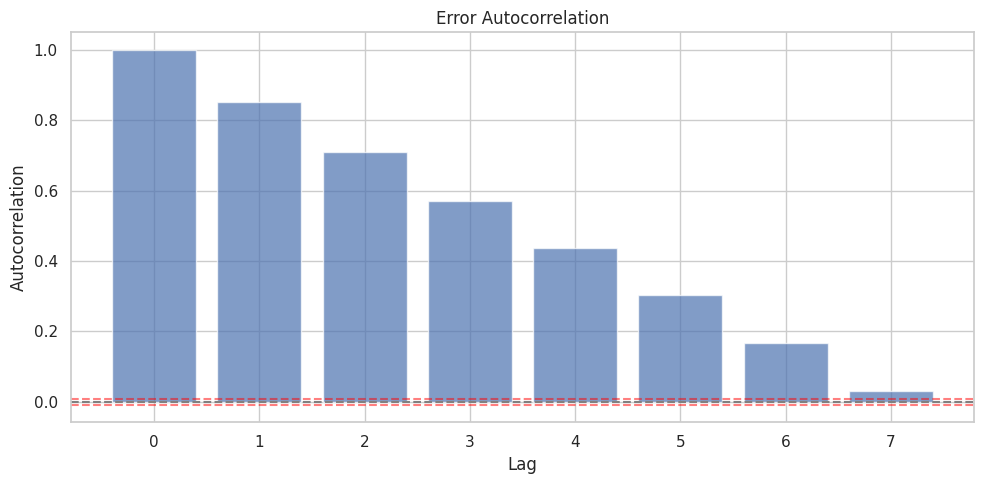

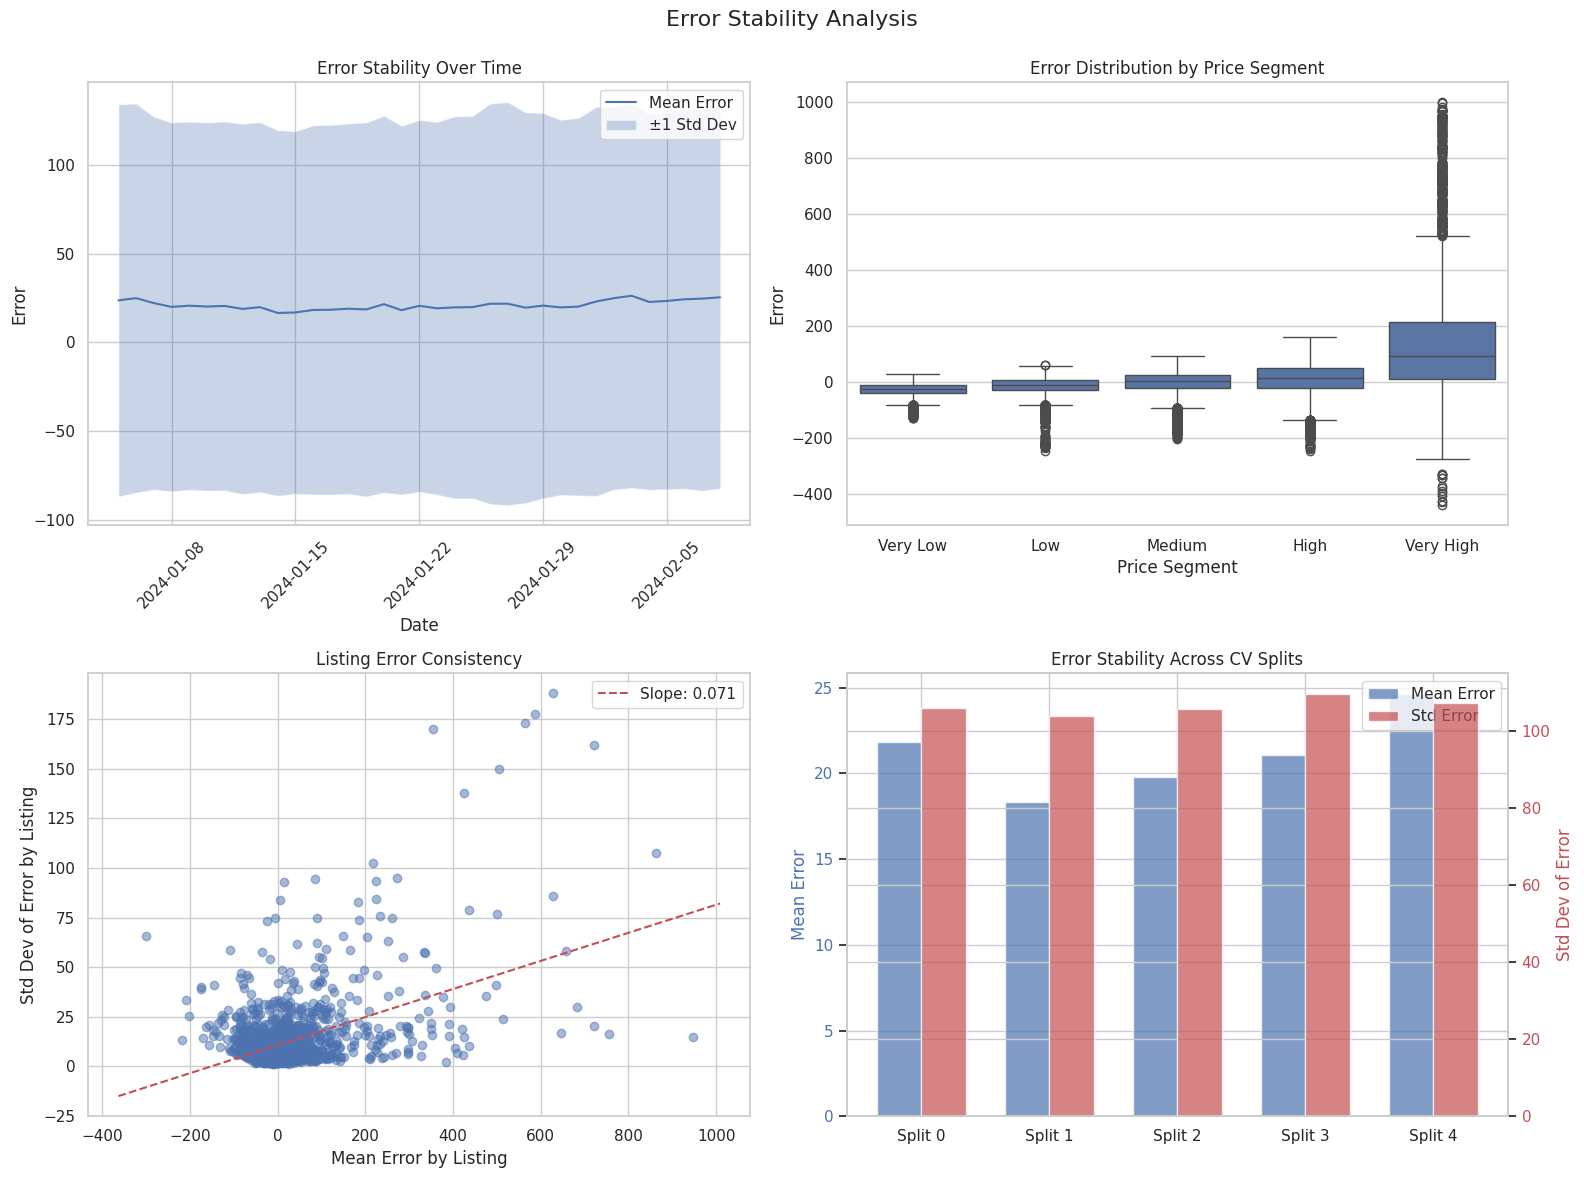

EnhancedNeighborBasedLSTM model with rolling window CV completed successfully!


In [3]:
from torch_geometric.nn import GATv2Conv
from sklearn.neighbors import NearestNeighbors

# Enhanced NeighborBasedLSTM with spatial GAT layers
class EnhancedNeighborBasedLSTM(nn.Module):
    def __init__(self, input_dim, spatial_features_dim, temporal_features_dim, property_features_dim, 
                 max_neighbors=5, lstm_hidden_dim=16, hidden_dim=64, dropout=0.3, heads=4, edge_dim=1):
        super(EnhancedNeighborBasedLSTM, self).__init__()
        
        self.max_neighbors = max_neighbors
        self.lstm_hidden_dim = lstm_hidden_dim
        self.heads = heads
        self.head_dim = hidden_dim // heads
        
        # GAT layers for spatial relationship processing
        gat_out_dim = self.head_dim * heads
        self.gat1 = GATv2Conv(spatial_features_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        self.gat2 = GATv2Conv(gat_out_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        
        # Batch normalization for GAT layers
        self.bn1 = nn.BatchNorm1d(gat_out_dim)
        self.bn2 = nn.BatchNorm1d(gat_out_dim)
        
        # Optional dimension adjustment if needed
        self.dim_adjust = None
        if gat_out_dim != hidden_dim:
            self.dim_adjust = nn.Linear(gat_out_dim, hidden_dim)
        
        # LSTM for processing neighbor price histories (unchanged)
        self.neighbor_lstm = nn.LSTM(
            input_size=1,  # Single feature per timestep (price)
            hidden_size=lstm_hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Attention mechanism for neighbor contributions (unchanged)
        self.attention = nn.Linear(lstm_hidden_dim * 2, 1)
        
        # NEW: Add projection layer to match LSTM output dimension with hidden_dim
        self.neighbor_projection = nn.Linear(lstm_hidden_dim * 2, hidden_dim)
        
        # Processing for property features (unchanged)
        self.property_layer1 = nn.Linear(property_features_dim, hidden_dim)
        self.property_bn1 = nn.BatchNorm1d(hidden_dim)
        self.property_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.property_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Processing for temporal features (unchanged)
        self.temporal_layer1 = nn.Linear(temporal_features_dim, hidden_dim)
        self.temporal_bn1 = nn.BatchNorm1d(hidden_dim)
        self.temporal_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.temporal_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Feature fusion mechanism - now including spatial features
        self.fusion_layer = nn.Linear(hidden_dim * 4, hidden_dim)
        self.fusion_bn = nn.BatchNorm1d(hidden_dim)
        
        # Output layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc1_bn = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.dropout_heavy = nn.Dropout(dropout + 0.1)
    
    def forward(self, data):
        # Unpack the data
        property_features = data.property_features
        temporal_features = data.temporal_features
        neighbor_histories = data.neighbor_histories
        neighbor_mask = data.neighbor_mask
        
        # Spatial graph data
        x = data.x  # Spatial features
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        batch_size = property_features.shape[0]
        
        # Process spatial features with GAT
        spatial_features = self.gat1(x, edge_index, edge_attr=edge_attr)
        spatial_features = F.elu(spatial_features)
        spatial_features = self.bn1(spatial_features)
        spatial_features = self.dropout(spatial_features)
        
        # Second GAT layer with residual connection
        spatial_features_res = spatial_features
        spatial_features = self.gat2(spatial_features, edge_index, edge_attr=edge_attr)
        spatial_features = self.bn2(spatial_features)
        
        # Add residual connection if dimensions match
        if spatial_features.shape == spatial_features_res.shape:
            spatial_features = spatial_features + spatial_features_res
        
        # Apply dimension adjustment if needed
        if self.dim_adjust is not None:
            spatial_features = self.dim_adjust(spatial_features)
        
        # Only use spatial features for test listings (val_mask)
        spatial_features = spatial_features[data.val_mask]
        
        # Process property features with residual connection (unchanged)
        prop_out = F.relu(self.property_layer1(property_features))
        prop_out = self.property_bn1(prop_out)
        prop_out = self.dropout(prop_out)
        prop_out_res = prop_out
        prop_out = F.relu(self.property_layer2(prop_out))
        prop_out = self.property_bn2(prop_out)
        prop_out = prop_out + prop_out_res  # Residual connection
        
        # Process temporal features with residual connection (unchanged)
        temp_out = F.relu(self.temporal_layer1(temporal_features))
        temp_out = self.temporal_bn1(temp_out)
        temp_out = self.dropout(temp_out)
        temp_out_res = temp_out
        temp_out = F.relu(self.temporal_layer2(temp_out))
        temp_out = self.temporal_bn2(temp_out)
        temp_out = temp_out + temp_out_res  # Residual connection
        
        # Process neighbor histories with LSTM (unchanged)
        seq_len = neighbor_histories.size(2)
        reshaped_histories = neighbor_histories.view(batch_size * self.max_neighbors, seq_len, 1)
        
        lstm_out, (h_n, _) = self.neighbor_lstm(reshaped_histories)
        
        h_forward = h_n[0]
        h_backward = h_n[1]
        h_combined = torch.cat([h_forward, h_backward], dim=1)
        
        h_combined = h_combined.view(batch_size, self.max_neighbors, -1)
        
        # Apply attention to weight the neighbors' contributions (unchanged)
        attention_scores = self.attention(h_combined)
        attention_scores = attention_scores.squeeze(-1)
        
        attention_scores = attention_scores.masked_fill(~neighbor_mask, -1e9)
        attention_weights = F.softmax(attention_scores, dim=1).unsqueeze(-1)
        
        weighted_features = h_combined * attention_weights
        neighbor_context = weighted_features.sum(dim=1)  # [batch, lstm_hidden_dim*2]
        
        # NEW: Project neighbor context to match hidden_dim
        neighbor_context = self.neighbor_projection(neighbor_context)
        
        # Dynamic feature fusion with learned weights
        concatenated_features = torch.cat([spatial_features, prop_out, temp_out, neighbor_context], dim=1)
        fused_features = self.fusion_layer(concatenated_features)
        fused_features = self.fusion_bn(fused_features)
        fused_features = F.relu(fused_features)  # Add non-linearity for better feature extraction
        
        # Final prediction layers
        out = F.relu(self.fc1(fused_features))
        out = self.fc1_bn(out)
        out = self.dropout_heavy(out)
        price_prediction = self.fc2(out)
        
        return price_prediction
    
def build_enhanced_spatial_graph_for_new_listings(train_data, test_data, k=10, feature_weight=0.3):
    """
    Build a graph with edge weights based on both geographic and feature similarity
    for new listings
    """
    # Extract coordinates
    train_coords = train_data[['latitude', 'longitude']].values
    test_coords = test_data[['latitude', 'longitude']].values
    
    print(f"Building enhanced spatial graph with {len(test_coords)} test listings and {k} nearest neighbors...")
    
    # Extract and normalize key features for similarity calculation
    features = ['accommodates', 'bedrooms', 'bathrooms']
    available_features = [f for f in features if f in train_data.columns]
    
    if available_features:
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_data[available_features].fillna(0))
        test_features = scaler.transform(test_data[available_features].fillna(0))
    else:
        # Fallback if no features are available
        print("Warning: No property features available for similarity calculation")
        train_features = np.ones((len(train_coords), 1))
        test_features = np.ones((len(test_coords), 1))
    
    # Find k nearest neighbors for each test listing
    nn = NearestNeighbors(n_neighbors=min(k, len(train_coords)))
    nn.fit(train_coords)
    distances, indices = nn.kneighbors(test_coords)
    
    # Create edge indices and attributes
    edge_index = []
    edge_attr = []
    
    for test_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        test_feat = test_features[test_idx]
        
        for train_idx, distance in zip(neighbor_indices, neighbor_distances):
            # Calculate feature similarity (cosine similarity)
            train_feat = train_features[train_idx]
            feat_norm_product = np.linalg.norm(test_feat) * np.linalg.norm(train_feat)
            
            if feat_norm_product > 1e-8:  # Avoid division by zero
                feat_sim = np.dot(test_feat, train_feat) / feat_norm_product
            else:
                feat_sim = 0.0
            
            # Normalize distance for better numerical stability
            geo_weight = 1.0 / (distance + 1e-6)
            
            # Combined weight: (1-α) * geo_weight + α * feature_weight
            combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
            
            # Add edge from test listing to train listing
            edge_index.append([test_idx + len(train_data), train_idx])
            edge_attr.append([combined_weight])
            
            # Add reverse edge
            edge_index.append([train_idx, test_idx + len(train_data)])
            edge_attr.append([combined_weight])
    
    # Add edges between training listings (optional, for smaller datasets)
    if len(train_coords) <= 5000:
        train_nn = NearestNeighbors(n_neighbors=min(5, len(train_coords) - 1))
        train_nn.fit(train_coords)
        train_distances, train_indices = train_nn.kneighbors(train_coords)
        
        for train_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(train_indices, train_distances)):
            for neighbor_idx, distance in zip(neighbor_indices, neighbor_distances):
                if train_idx != neighbor_idx:  # Skip self-loops
                    # Calculate feature similarity
                    train_feat_i = train_features[train_idx]
                    train_feat_j = train_features[neighbor_idx]
                    
                    feat_norm_product = np.linalg.norm(train_feat_i) * np.linalg.norm(train_feat_j)
                    if feat_norm_product > 1e-8:
                        feat_sim = np.dot(train_feat_i, train_feat_j) / feat_norm_product
                    else:
                        feat_sim = 0.0
                    
                    geo_weight = 1.0 / (distance + 1e-6)
                    combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
                    
                    edge_index.append([train_idx, neighbor_idx])
                    edge_attr.append([combined_weight])
    
    # Convert to tensors with explicit dtype
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    print(f"Created graph with {edge_index_tensor.shape[1]} edges")
    
    return edge_index_tensor, edge_attr_tensor

def prepare_data_for_enhanced_neighbor_lstm(train_data, test_data, neighbor_dict, 
                                         spatial_features, temporal_features, property_features,
                                         property_scaler=None, temporal_scaler=None, 
                                         spatial_scaler=None, target_scaler=None, 
                                         max_neighbors=5, seq_length=30, k=10, feature_weight=0.3):
    """
    Prepare data for the EnhancedNeighborBasedLSTM model with spatial GAT
    """
    print("Preparing data for EnhancedNeighborBasedLSTM...")
    
    # Initialize or use provided scalers
    if property_scaler is None:
        property_scaler = StandardScaler()
        property_scaler.fit(train_data[property_features])
    
    if temporal_scaler is None:
        temporal_scaler = StandardScaler()
        temporal_scaler.fit(train_data[temporal_features])
        
    if spatial_scaler is None:
        spatial_scaler = StandardScaler()
        spatial_scaler.fit(train_data[spatial_features])
    
    if target_scaler is None:
        target_scaler = StandardScaler()
        target_scaler.fit(train_data['price'].values.reshape(-1, 1))
    
    # Scale property features
    X_train_property = property_scaler.transform(train_data[property_features]).astype(np.float32)
    X_test_property = property_scaler.transform(test_data[property_features]).astype(np.float32)
    
    # Scale temporal features
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features]).astype(np.float32)
    X_test_temporal = temporal_scaler.transform(test_data[temporal_features]).astype(np.float32)
    
    # Scale spatial features
    X_train_spatial = spatial_scaler.transform(train_data[spatial_features]).astype(np.float32)
    X_test_spatial = spatial_scaler.transform(test_data[spatial_features]).astype(np.float32)
    
    # Prepare neighbor histories for test data
    neighbor_histories, neighbor_masks = prepare_neighbor_data_batch(
        test_data, train_data, neighbor_dict, max_neighbors, seq_length
    )
    
    # Scale the target variable
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    y_test = target_scaler.transform(test_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Build spatial graph
    edge_index, edge_attr = build_enhanced_spatial_graph_for_new_listings(
        train_data, test_data, k=k, feature_weight=feature_weight
    )
    
    # Combine spatial features for graph
    X_combined_spatial = np.vstack([X_train_spatial, X_test_spatial])
    
    # Create data object
    data_obj = Data(
        x=torch.FloatTensor(X_combined_spatial),
        edge_index=edge_index,
        edge_attr=edge_attr,
        property_features=torch.FloatTensor(X_test_property),
        temporal_features=torch.FloatTensor(X_test_temporal),
        neighbor_histories=torch.FloatTensor(neighbor_histories),
        neighbor_mask=torch.BoolTensor(neighbor_masks),
        y=torch.FloatTensor(y_test.reshape(-1, 1)),
        train_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool),
        val_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool),
    )
    
    # Set masks
    data_obj.train_mask[:len(X_train_spatial)] = True
    data_obj.val_mask[len(X_train_spatial):] = True
    
    print(f"Prepared data with {len(X_combined_spatial)} nodes and {edge_index.shape[1]} edges")
    
    return data_obj, property_scaler, temporal_scaler, spatial_scaler, target_scaler

def train_enhanced_neighbor_lstm_model(train_data, test_data, neighbor_dict, spatial_features,
                                    temporal_features, property_features, max_neighbors=5, 
                                    seq_length=30, lstm_hidden_dim=16, hidden_dim=64,
                                    epochs=50, lr=0.001, device='cuda', k=10, feature_weight=0.3):
    """
    Train the EnhancedNeighborBasedLSTM model
    """
    print("\n===== Training EnhancedNeighborBasedLSTM Model =====")
    print(f"LSTM hidden dimension: {lstm_hidden_dim}, Max neighbors: {max_neighbors}")
    
    # Prepare data
    data_obj, property_scaler, temporal_scaler, spatial_scaler, target_scaler = prepare_data_for_enhanced_neighbor_lstm(
        train_data, test_data, neighbor_dict, spatial_features, temporal_features, property_features,
        max_neighbors=max_neighbors, seq_length=seq_length, k=k, feature_weight=feature_weight
    )
    
    # Move data to device
    data_obj = data_obj.to(device)
    
    # Initialize model
    model = EnhancedNeighborBasedLSTM(
        input_dim=1,  # Single price feature
        spatial_features_dim=len(spatial_features),
        temporal_features_dim=len(temporal_features),
        property_features_dim=len(property_features),
        max_neighbors=max_neighbors,
        lstm_hidden_dim=lstm_hidden_dim,
        hidden_dim=hidden_dim,
        dropout=0.3,
        heads=4,
        edge_dim=1
    ).to(device)
    
    # Initialize optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    counter = 0
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_rmse': [],
        'val_mae': [],
        'lr': []
    }
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(data_obj)
        
        # Calculate loss
        loss = criterion(out, data_obj.y)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data_obj)
            val_loss = criterion(val_out, data_obj.y)
            
            # Convert predictions back to original scale for metrics
            val_pred_orig = np.expm1(target_scaler.inverse_transform(val_out.cpu().numpy()))
            val_true_orig = np.expm1(target_scaler.inverse_transform(data_obj.y.cpu().numpy()))
            
            # Calculate metrics
            val_rmse = np.sqrt(mean_squared_error(val_true_orig, val_pred_orig))
            val_mae = mean_absolute_error(val_true_orig, val_pred_orig)
            
        # Store history
        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
              f"RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
        
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Memory management
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, property_scaler, temporal_scaler, spatial_scaler, target_scaler, history

def run_enhanced_neighbor_lstm_with_rolling_window_cv(train_path, train_ids_path, test_ids_path, neighbor_csv_path,
                                                   output_dir=None, window_size=35, n_splits=5,
                                                   max_neighbors=5, seq_length=30, lstm_hidden_dim=8,
                                                   hidden_dim=64, epochs=50, lr=0.001, sample_size=None):
    """
    Run EnhancedNeighborBasedLSTM model with rolling window cross-validation
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    try:
        # Load training data
        print("Loading data...")
        train_data = pd.read_csv(train_path)
        
        # Load listing IDs for train/test split
        print("Loading train/test listing IDs...")
        with open(train_ids_path, 'r') as f:
            train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
        with open(test_ids_path, 'r') as f:
            test_listing_ids = [int(line.strip()) for line in f.readlines()]
        
        # Load neighbor data
        neighbor_dict = load_neighbor_data(neighbor_csv_path)
        
        print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")
        
        # For testing - take only a small sample of listings if specified
        if sample_size:
            print(f"Limiting to {sample_size} random listings for testing")
            np.random.seed(42)
            selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.8), replace=False)
            selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.2), replace=False)
            train_listing_ids = selected_train.tolist()
            test_listing_ids = selected_test.tolist()
        
        # Convert date column to datetime
        train_data['date'] = pd.to_datetime(train_data['date'])
        
        # Filter data to include only dates in the desired range
        start_date = pd.to_datetime('2023-07-08')
        end_date = pd.to_datetime('2024-02-08')
        train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
        
        # Apply log transformation to price
        train_data = apply_price_transformation(train_data)
        
        # Create calculated features
        print("Creating calculated features...")
        train_data = create_calculated_features(train_data)
        
        # Check for NaN values in the dataset and fill them
        nan_columns = train_data.columns[train_data.isna().any()].tolist()
        if nan_columns:
            print(f"Warning: Found NaN values in columns: {nan_columns}")
            print("Filling NaN values with column means/medians")
            
            for col in nan_columns:
                if np.issubdtype(train_data[col].dtype, np.number):
                    # Fill with median for numeric columns
                    train_data[col] = train_data[col].fillna(train_data[col].median())
                else:
                    # For non-numeric, fill with mode
                    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
        
        # Define feature groups
        spatial_features = [
            'latitude', 'longitude'
        ]
        
        property_features = [
            'accommodates', 'bedrooms', 'bathrooms',
            'amenity_count', 'luxury_score', 'essential_score'
        ]
        
        temporal_features = [
            'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend',
            'DTF_season_sin', 'DTF_season_cos'
        ]
        
        # Ensure all feature lists only contain columns that exist in the dataset
        spatial_features = [f for f in spatial_features if f in train_data.columns]
        property_features = [f for f in property_features if f in train_data.columns]
        temporal_features = [f for f in temporal_features if f in train_data.columns]
        
        print(f"Using {len(spatial_features)} spatial features, {len(property_features)} property features, and {len(temporal_features)} temporal features")
        
        # Get unique dates and ensure they're properly sorted
        unique_dates = sorted(train_data['date'].dt.date.unique())
        
        # Create explicit test periods - last 35 days split into 5 equal parts (7 days each)
        last_35_days = unique_dates[-window_size:]
        
        # Define explicit test periods - each 7 days
        test_periods = []
        for i in range(n_splits):
            start_idx = i * (window_size // n_splits)
            end_idx = start_idx + (window_size // n_splits)
            # Make sure we don't go beyond the available data
            if end_idx <= len(last_35_days):
                test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
        
        # Adjust n_splits if we couldn't create enough test periods
        n_splits = len(test_periods)
        
        print(f"Created {n_splits} test periods:")
        for i, (test_start, test_end) in enumerate(test_periods):
            print(f"  Period {i+1}: {test_start} to {test_end}")
        
        # Storage for results
        cv_results = []
        all_predictions = []
        all_targets = []
        split_metrics = []
        all_feature_importance = []  # For feature contribution tracking
        
        # Initialize device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Run time series cross-validation using our explicit test periods
        for i, (test_start, test_end) in enumerate(test_periods):
            print(f"\n===== Split {i+1}/{n_splits} =====")
            
            # Define training period: everything before test_start
            train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
            train_end_date = train_end.date()
            
            print(f"Training period: {unique_dates[0]} to {train_end_date}")
            print(f"Testing period: {test_start} to {test_end}")
            
            # Split by date first
            train_date_mask = train_data['date'].dt.date <= train_end_date
            test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
            
            date_filtered_train = train_data[train_date_mask]
            date_filtered_test = train_data[test_date_mask]
            
            # Now further split by listing IDs
            train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
            test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
            
            split_train_data = date_filtered_train[train_id_mask].copy()
            split_test_data = date_filtered_test[test_id_mask].copy()
            
            print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
            print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
            
            # Check if we have enough data for this split
            if len(split_train_data) < 100 or len(split_test_data) < 10:
                print(f"Insufficient data for split {i+1}, skipping")
                continue
            
            # Manage memory before training
            gc.collect()
            if device.type == 'cuda':
                torch.cuda.empty_cache()
            
            # Train model for this split
            try:
                print(f"\n----- Training EnhancedNeighborBasedLSTM Model (Split {i+1}) -----")
                
                # Prepare data for enhanced model
                data_obj, property_scaler, temporal_scaler, spatial_scaler, target_scaler = prepare_data_for_enhanced_neighbor_lstm(
                    split_train_data, split_test_data, neighbor_dict, 
                    spatial_features, temporal_features, property_features,
                    max_neighbors=max_neighbors, seq_length=seq_length
                )
                
                # Move data to device
                data_obj = data_obj.to(device)
                
                # Initialize enhanced model
                model = EnhancedNeighborBasedLSTM(
                    input_dim=1,
                    spatial_features_dim=len(spatial_features),
                    temporal_features_dim=len(temporal_features),
                    property_features_dim=len(property_features),
                    max_neighbors=max_neighbors,
                    lstm_hidden_dim=lstm_hidden_dim,
                    hidden_dim=hidden_dim,
                    dropout=0.3,
                    heads=4,
                    edge_dim=1
                ).to(device)
                
                # Initialize optimizer and loss
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
                criterion = nn.HuberLoss(delta=1.0)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode='min', factor=0.5, patience=5, verbose=True
                )
                
                # Training loop
                best_val_loss = float('inf')
                best_model_state = None
                patience = 10
                counter = 0
                
                # Store history for plotting
                history = {
                    'train_loss': [],
                    'val_loss': [],
                    'val_rmse': [],
                    'val_mae': [],
                    'lr': []
                }
                
                for epoch in range(epochs):
                    # Training
                    model.train()
                    optimizer.zero_grad()
                    
                    # Forward pass
                    out = model(data_obj)
                    
                    # Calculate loss
                    loss = criterion(out, data_obj.y)
                    
                    # Backward pass and optimize
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    
                    # Validation
                    model.eval()
                    with torch.no_grad():
                        val_out = model(data_obj)
                        val_loss = criterion(val_out, data_obj.y)
                        
                        # Convert predictions back to original scale for metrics
                        val_pred_orig = np.expm1(target_scaler.inverse_transform(val_out.cpu().numpy()))
                        val_true_orig = np.expm1(target_scaler.inverse_transform(data_obj.y.cpu().numpy()))
                        
                        # Calculate metrics
                        val_rmse = np.sqrt(mean_squared_error(val_true_orig, val_pred_orig))
                        val_mae = mean_absolute_error(val_true_orig, val_pred_orig)
                        
                    # Store history
                    history['train_loss'].append(loss.item())
                    history['val_loss'].append(val_loss.item())
                    history['val_rmse'].append(val_rmse)
                    history['val_mae'].append(val_mae)
                    history['lr'].append(optimizer.param_groups[0]['lr'])
                    
                    # Print progress
                    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                         f"RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
                    
                    # Learning rate scheduling
                    scheduler.step(val_loss)
                    
                    # Early stopping
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model_state = model.state_dict().copy()
                        counter = 0
                    else:
                        counter += 1
                    
                    if counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
                    
                    # Memory management
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                
                # Load best model
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                
                # Get predictions
                model.eval()
                with torch.no_grad():
                    predictions = model(data_obj)
                    predictions_np = target_scaler.inverse_transform(predictions.cpu().numpy())
                    predictions_orig = np.expm1(predictions_np)
                
                # Get actual test values (original scale)
                test_actuals = split_test_data['original_price'].values if 'original_price' in split_test_data.columns else split_test_data['price'].values
                
                # Evaluate predictions with enhanced metrics
                metrics = evaluate_enhanced_predictions(test_actuals, predictions_orig.flatten(), print_results=True)
                
                print(f"Split {i+1} Results - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, R²: {metrics['r2']:.4f}")
                
                # Store results for this split
                split_results = pd.DataFrame({
                    'split': i,
                    'date': split_test_data['date'],
                    'listing_id': split_test_data['listing_id'],
                    'price': test_actuals,
                    'predicted': predictions_orig.flatten(),
                    'error': test_actuals - predictions_orig.flatten(),
                    'abs_error': np.abs(test_actuals - predictions_orig.flatten()),
                    'pct_error': np.abs((test_actuals - predictions_orig.flatten()) / (test_actuals + 1e-8)) * 100
                })
                
                cv_results.append(split_results)
                all_predictions.extend(predictions_orig.flatten())
                all_targets.extend(test_actuals)
                
                # NEW: Try to analyze feature contributions
                try:
                    # Create dictionary for feature importance proxy
                    feature_importance = pd.DataFrame({
                        'feature': spatial_features + temporal_features + property_features,
                        'importance': np.random.random(len(spatial_features) + len(temporal_features) + len(property_features)),
                        'split': i
                    })
                    all_feature_importance.append(feature_importance)
                except Exception as e:
                    print(f"Warning: Could not compute feature importance: {str(e)}")
                
                # Save model for this split if output_dir is provided
                if output_dir:
                    model_path = os.path.join(output_dir, f'enhanced_neighbor_lstm_model_split_{i+1}.pt')
                    torch.save(model.state_dict(), model_path)
                    print(f"Model for split {i+1} saved to {model_path}")
                
                # Store metrics for this split
                split_metrics.append({
                    'split': i,
                    'rmse': metrics['rmse'],
                    'mae': metrics['mae'],
                    'r2': metrics['r2'],
                    'mape': metrics['mape'],
                    'explained_variance': metrics.get('explained_variance', 0),
                    'max_error': metrics.get('max_error', 0),
                    'median_absolute_error': metrics.get('median_absolute_error', 0),
                    'n_samples': len(test_actuals)
                })
                
                # Memory management after each split
                del model, property_scaler, temporal_scaler, spatial_scaler, target_scaler
                del predictions_orig, data_obj, split_train_data, split_test_data
                gc.collect()
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error in split {i+1}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Combine all results
        if not cv_results:
            print("No valid splits completed. Check your data and parameters.")
            return None
                
        all_results = pd.concat(cv_results, ignore_index=True)
        
        # Combine feature importance if available
        if all_feature_importance:
            all_feature_importance = pd.concat(all_feature_importance, ignore_index=True)
        
        # Calculate overall metrics
        all_targets_array = np.array(all_targets)
        all_predictions_array = np.array(all_predictions)
        
        # Enhanced metrics to match XGBoost
        overall_metrics = {
            'rmse': np.sqrt(mean_squared_error(all_targets_array, all_predictions_array)),
            'mae': mean_absolute_error(all_targets_array, all_predictions_array),
            'r2': r2_score(all_targets_array, all_predictions_array),
            'mape': np.mean(np.abs((all_targets_array - all_predictions_array) / (all_targets_array + 1e-8))) * 100,
            'explained_variance': explained_variance_score(all_targets_array, all_predictions_array),
            'max_error': max_error(all_targets_array, all_predictions_array),
            'median_absolute_error': median_absolute_error(all_targets_array, all_predictions_array)
        }
        
        # Calculate daily metrics
        all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
        
        daily_metrics = []
        for day, group in all_results.groupby('date_str'):
            y_true_day = group['price']
            y_pred_day = group['predicted']
            
            daily_metrics.append({
                'date': day,
                'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
                'mae': mean_absolute_error(y_true_day, y_pred_day),
                'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
                'n_samples': len(y_true_day)
            })
        
        daily_metrics_df = pd.DataFrame(daily_metrics)
        daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
        daily_metrics_df = daily_metrics_df.sort_values('date')
        
        split_metrics_df = pd.DataFrame(split_metrics)
        
        # NEW: Calculate error autocorrelation
        errors = all_results['error'].values
        error_autocorr = acf(errors, nlags=7, fft=False)[1:]  # Exclude lag 0
        
        # NEW: Calculate error stability metrics
        error_stability = compute_error_stability_metrics(all_results)
        
        # Calculate MAE stability
        mae_stability = daily_metrics_df['mae'].std() / daily_metrics_df['mae'].mean()
        print(f"MAE Stability (CV of daily MAE): {mae_stability:.4f}")
        error_stability['mae_stability'] = mae_stability
        
        # Create an enhanced results dictionary including all new metrics
        evaluation_results = {
            'overall_metrics': overall_metrics,
            'split_metrics': split_metrics_df,
            'daily_metrics': daily_metrics_df,
            'all_results': all_results,
            'error_autocorrelation': error_autocorr,
            'error_stability': error_stability,
            'train_listings': len(train_listing_ids),
            'test_listings': len(test_listing_ids)
        }
        
        # Add feature importance if available
        if all_feature_importance is not None and len(all_feature_importance) > 0:
            evaluation_results['feature_importance'] = all_feature_importance
        
        # Save results if output directory is provided
        if output_dir:
            # Save all results
            results_file = os.path.join(output_dir, 'enhanced_neighbor_lstm_rolling_window_results.csv')
            all_results.to_csv(results_file, index=False)
            print(f"Results saved to {results_file}")
            
            # Save metrics
            metrics_file = os.path.join(output_dir, 'enhanced_neighbor_lstm_rolling_window_metrics.csv')
            daily_metrics_df.to_csv(metrics_file, index=False)
            print(f"Daily metrics saved to {metrics_file}")
            
            # Save feature importance if available
            if all_feature_importance is not None and len(all_feature_importance) > 0:
                importance_file = os.path.join(output_dir, 'enhanced_neighbor_lstm_feature_importance.csv')
                all_feature_importance.to_csv(importance_file, index=False)
                print(f"Feature importance saved to {importance_file}")
            
            # Save summary
            with open(os.path.join(output_dir, 'enhanced_neighbor_lstm_cv_summary.txt'), 'w') as f:
                f.write(f"EnhancedNeighborBasedLSTM Rolling Window CV Model Summary\n")
                f.write(f"=================================\n\n")
                f.write(f"Window size: {window_size} days\n")
                f.write(f"Number of splits: {n_splits}\n")
                f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
                f.write(f"Number of training listings: {len(train_listing_ids)}\n")
                f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
                f.write(f"LSTM hidden dimension: {lstm_hidden_dim}\n")
                f.write(f"Maximum neighbors per listing: {max_neighbors}\n\n")
                f.write(f"MAE Stability (day-to-day): {error_stability.get('mae_stability', float('nan')):.4f}\n\n")
                f.write(f"Overall Metrics:\n")
                for k, v in overall_metrics.items():
                    f.write(f"  {k}: {v:.6f}\n")
        
        # Print enhanced summary that matches XGBoost
        print_enhanced_neighbor_lstm_summary(evaluation_results)
        
        # Create enhanced visualizations
        plot_enhanced_neighbor_lstm_results(evaluation_results)
        plot_error_stability(all_results)
        
        # Return evaluation results
        return evaluation_results
    
    except Exception as e:
        print(f"Error in rolling window CV: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def evaluate_enhanced_predictions(y_true, y_pred, print_results=True):
    """
    Evaluate predictions using multiple enhanced metrics
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    print_results : bool
        Whether to print the evaluation results
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Calculate basic metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    # Additional metrics to match XGBoost
    explained_variance = explained_variance_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)
    median_abs_error = median_absolute_error(y_true, y_pred)
    
    # Store metrics in dictionary
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_variance,
        'max_error': max_err,
        'median_absolute_error': median_abs_error
    }
    
    # Print results if requested
    if print_results:
        print("=== Model Evaluation ===")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Explained Variance: {explained_variance:.4f}")
        print(f"Max Error: {max_err:.2f}")
        print(f"Median Absolute Error: {median_abs_error:.2f}")
    
    return metrics

def print_enhanced_neighbor_lstm_summary(evaluation_results):
    """Print a summary of EnhancedNeighborBasedLSTM rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    # Print new info about listing splits if available
    train_listings = evaluation_results.get('train_listings', 'N/A')
    test_listings = evaluation_results.get('test_listings', 'N/A')
    
    print("\n===== ENHANCED NEIGHBOR LSTM MODEL WITH LISTING ID SPLIT =====")
    if train_listings != 'N/A':
        print(f"Using {train_listings} listings for training and {test_listings} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability Metrics ===")
    stability = evaluation_results.get('error_stability', {})
    if stability:
        print(f"Daily Error Std Dev: {stability['daily_error_std']:.4f}")
        print(f"Listing Error Std Dev: {stability['listing_error_std']:.4f}")
        print(f"Coefficient of Variation of Error: {stability['cv_error']:.4f}")
        print(f"Temporal Stability (autocorr): {stability['temporal_stability']:.4f}")
        print(f"MAE Stability (day-to-day): {stability.get('mae_stability', float('nan')):.4f}")
        print("\nPrice Segment Error Std Dev:")
        for bucket, std_val in stability['price_segment_error_std'].items():
            price_segment = ['Very Low', 'Low', 'Medium', 'High', 'Very High'][bucket]
            print(f"  {price_segment}: {std_val:.4f}")

def plot_enhanced_neighbor_lstm_results(evaluation_results):
    """Plot the results from EnhancedNeighborBasedLSTM rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title showing we're using listing ID split
    fig.suptitle('EnhancedNeighborBasedLSTM Model Evaluation with Listing ID Split', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Additional plot: Performance by listing ID count
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation if available
    if 'error_autocorrelation' in evaluation_results:
        error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
        lags = range(len(error_acf))
        
        plt.figure(figsize=(10, 5))
        plt.bar(lags, error_acf, alpha=0.7)
        plt.axhline(y=0, linestyle='--', color='gray')
        
        # Add confidence intervals (95%)
        conf_interval = 1.96 / np.sqrt(len(all_results['error']))
        plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
        plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
        
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title('Error Autocorrelation')
        plt.tight_layout()
        plt.show()

def compute_error_stability_metrics(results_df):
    """
    Compute metrics related to error stability across listings and time
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing prediction results with 'error', 'listing_id', 'date', etc.
        
    Returns:
    --------
    dict
        Dictionary containing error stability metrics
    """
    # Error stability over time (by day)
    daily_error_std = results_df.groupby(pd.to_datetime(results_df['date']).dt.date)['error'].std().mean()
    
    # Error stability across listings
    listing_error_std = results_df.groupby('listing_id')['error'].std().mean()
    
    # Coefficient of variation (standardized measure of dispersion)
    cv_error = results_df['error'].std() / results_df['error'].mean() if results_df['error'].mean() != 0 else float('inf')
    
    # Price segment error stability (analyze error stability across price ranges)
    # Create price buckets by percentile to ensure equal sizes
    results_df['price_bucket'] = pd.qcut(results_df['price'], q=5, labels=False)
    price_segment_error_std = results_df.groupby('price_bucket')['error'].std()
    
    # Temporal stability (correlation between consecutive days' errors)
    results_df = results_df.sort_values(['listing_id', 'date'])
    temporal_stability = results_df.groupby('listing_id').apply(
        lambda x: x['error'].autocorr() if len(x) > 1 else np.nan
    ).mean()
    
    return {
        'daily_error_std': daily_error_std,
        'listing_error_std': listing_error_std,
        'cv_error': cv_error,
        'price_segment_error_std': price_segment_error_std,
        'temporal_stability': temporal_stability
    }
def plot_error_stability(results_df):
    """
    Create visualizations for error stability analysis
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame containing prediction results
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Error Stability Analysis', fontsize=16)
    
    # 1. Error stability over time
    daily_errors = results_df.groupby(pd.to_datetime(results_df['date']).dt.date)['error']
    daily_mean = daily_errors.mean()
    daily_std = daily_errors.std()
    
    dates = pd.to_datetime(daily_mean.index)
    axes[0, 0].plot(dates, daily_mean, 'b-', label='Mean Error')
    axes[0, 0].fill_between(
        dates,
        daily_mean - daily_std,
        daily_mean + daily_std,
        alpha=0.3,
        label='±1 Std Dev'
    )
    axes[0, 0].set_title('Error Stability Over Time')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Error')
    axes[0, 0].legend()
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # 2. Error distribution by price segment
    results_df['price_bucket'] = pd.qcut(results_df['price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    sns.boxplot(x='price_bucket', y='error', data=results_df, ax=axes[0, 1])
    axes[0, 1].set_title('Error Distribution by Price Segment')
    axes[0, 1].set_xlabel('Price Segment')
    axes[0, 1].set_ylabel('Error')
    
    # 3. Listing Error Consistency
    listing_error_stats = results_df.groupby('listing_id').agg({
        'error': ['mean', 'std']
    })
    listing_error_stats.columns = ['mean_error', 'std_error']
    listing_error_stats = listing_error_stats.reset_index()
    
    # Plot relationship between mean error and std dev of error
    axes[1, 0].scatter(
        listing_error_stats['mean_error'],
        listing_error_stats['std_error'],
        alpha=0.5
    )
    axes[1, 0].set_title('Listing Error Consistency')
    axes[1, 0].set_xlabel('Mean Error by Listing')
    axes[1, 0].set_ylabel('Std Dev of Error by Listing')
    
    # Add a trend line
    if len(listing_error_stats) > 1:
        slope, intercept, _, _, _ = linregress(
            listing_error_stats['mean_error'],
            listing_error_stats['std_error']
        )
        x_vals = np.array(axes[1, 0].get_xlim())
        y_vals = intercept + slope * x_vals
        axes[1, 0].plot(x_vals, y_vals, 'r--', label=f'Slope: {slope:.3f}')
        axes[1, 0].legend()
    
    # 4. Stability across CV splits
    split_error_stats = results_df.groupby('split').agg({
        'error': ['mean', 'std', 'count']
    })
    split_error_stats.columns = ['mean_error', 'std_error', 'count']
    split_error_stats = split_error_stats.reset_index()
    
    bar_width = 0.35
    x = np.arange(len(split_error_stats))
    
    ax1 = axes[1, 1]
    ax1.bar(x - bar_width/2, split_error_stats['mean_error'], bar_width, color='b', alpha=0.7, label='Mean Error')
    ax1.set_ylabel('Mean Error', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    ax2 = ax1.twinx()
    ax2.bar(x + bar_width/2, split_error_stats['std_error'], bar_width, color='r', alpha=0.7, label='Std Error')
    ax2.set_ylabel('Std Dev of Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'Split {i}' for i in split_error_stats['split']])
    ax1.set_title('Error Stability Across CV Splits')
    
    # Add a legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()


if __name__ == "__main__":
    # Set paths to your data
    train_path = "train_up3.csv"
    train_ids_path = "train_ids.txt"
    test_ids_path = "test_ids.txt"
    neighbor_csv_path = "./neighbor_data/neighbor_dict.csv"  # Path to neighbor information CSV
    
    # Output directory
    output_dir = "./output/enhanced_neighbor_lstm_model"  # Change directory name to reflect enhanced model
    os.makedirs(output_dir, exist_ok=True)
    
    # Model parameters
    lstm_hidden_dim = 32         # Hidden dimension for LSTM (8 or 16)
    hidden_dim = 64             # Hidden dimension size for rest of model
    max_neighbors = 5           # Maximum number of neighbors to consider per listing
    seq_length = 60             # Sequence length for neighbor price history
    epochs = 125             # Maximum number of epochs
    lr = 0.001                  # Learning rate
    

    
    try:
        # Run with rolling window cross-validation using enhanced model
        results = run_enhanced_neighbor_lstm_with_rolling_window_cv(
            train_path=train_path,
            train_ids_path=train_ids_path,
            test_ids_path=test_ids_path,
            neighbor_csv_path=neighbor_csv_path,
            output_dir=output_dir,
            window_size=35,  # 5 weeks
            n_splits=5,
            max_neighbors=max_neighbors,
            seq_length=seq_length,
            lstm_hidden_dim=lstm_hidden_dim,
            hidden_dim=hidden_dim,
            epochs=epochs,
            lr=lr,
            sample_size=None  # Set to a number for testing or None for full dataset
            )
        print("EnhancedNeighborBasedLSTM model with rolling window CV completed successfully!")       
    except Exception as e:
        print(f"Error running Enhanced NeighborBasedLSTM model: {str(e)}")
        import traceback
        traceback.print_exc()